## Demo of a Pizza Ordering Chatbot using LLMs

This demo was created by Arvind Singh Gulati (https://www.linkedin.com/in/arvindsg/) for the NASSCOM Engineering and Design Summit keynote lecture on a pizza order-taking chatbot implementation using ChatGPT.  The video of Arvind demoing this order-taking chatbot is on Youtube at https://www.youtube.com/watch?v=2gkWBz52Yzg

In [1]:
%pip install -U pydantic openai langchain langchain-community langgraph langchain-anthropic langchain-openai langgraph-checkpoint-sqlite


   ---------------------------------------- 0.0/1.9 MB ? eta -:--:--
   -------------------------------- ------- 1.6/1.9 MB 8.4 MB/s eta 0:00:01
   ---------------------------------------- 1.9/1.9 MB 7.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.0 MB ? eta -:--:--
   ---------------------------------------- 1.0/1.0 MB 5.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.3 MB ? eta -:--:--
   -------------------------- ------------- 1.6/2.3 MB 8.3 MB/s eta 0:00:01
   ---------------------------------------- 2.3/2.3 MB 7.0 MB/s eta 0:00:00
  Attempting uninstall: pydantic-core
    Found existing installation: pydantic_core 2.20.1
    Uninstalling pydantic_core-2.20.1:
      Successfully uninstalled pydantic_core-2.20.1
  Attempting uninstall: pydantic
    Found existing installation: pydantic 2.8.2
    Uninstalling pydantic-2.8.2:
      Successfully uninstalled pydantic-2.8.2
  Attempting uninstall: openai
    Found existing installation: opena

You need to get yourself either an OpenAI key (for GPT-4o-mini) or an Anthropic key (for the Claude Sonnet LLM which has a free tier - Haiku does not work very well for this task).
The OpenAI API responds way faster and works very well, but you have to pay for it from the beginning (very cheap though - around 1.5 dollars for a million characters as of September 2024).  Once you change the following box (replacing the text '<your key>' with the API key in quotes) you can run the rest of the code to the end - no changes needed.

In [2]:
import os
os.environ['OPENAI_API_KEY'] = '<your key>'              # Use this preferrably - it's faster
assert "OPENAI_API_KEY" in os.environ
#os.environ['ANTHROPIC_API_KEY'] = '<your key>'
#assert "ANTHROPIC_API_KEY" in os.environ
#assert "LANGCHAIN_API_KEY" in os.environ

In [3]:
from langchain_openai import ChatOpenAI                  # Use this preferrably - faster
from langchain_anthropic import ChatAnthropic

In [4]:
import os
os.environ["LANGCHAIN_TRACING_V2"] = "false"  # Make true for LangSmith
os.environ["LANGCHAIN_PROJECT"] = "nasscom"
# LANGCHAIN_ENDPOINT="https://api.smith.langchain.com"

In [5]:
VALID_SIZES = ["small", "medium", "large"]
VALID_TOPPINGS = ["capsicum", "tomatoes", "olives", "mushrooms", "onions", "jalapenos", "pineapple", "pepperoni"]
VALID_SIDES = ["garlic bread", "choco lava cake", "chicken taco"]

In [6]:
from typing import List
from langchain.tools import tool

order_count = 0
order_status_db={}



def pizza_order(pizza_size: str, pizza_toppings: List[str], side_items: List[str]) -> str:
    """
    Places an order for a pizza with the specified size, toppings, and side items. Must be invoked once the order details are confirmed by the user

    Args:
        pizza_size (str): The size of the pizza to order (e.g., 'small', 'medium', 'large').
        pizza_toppings (List[str]): A list of toppings to add to the pizza.
        side_items (List[str]): A list of side items to include with the order.

    Returns:
        str: A message indicating whether the order was placed successfully, or an error message if there were invalid inputs.

    Example:
        >>> pizza_order('large', ['pepperoni', 'mushrooms'], ['garlic bread', 'soda'])
        "Your order has been placed successfully! Here are the details:\n{'pizza_size': 'large', 'pizza_toppings': ['pepperoni', 'mushrooms'], 'side_items': ['garlic bread', 'soda']}"
    """

    global order_count
    
    # Basic validation and order processing logic
    if pizza_size not in VALID_SIZES:
        return f"Error: Invalid pizza size '{pizza_size}'. Please choose from {VALID_SIZES}."
    
    invalid_toppings = [topping for topping in pizza_toppings if topping not in VALID_TOPPINGS]
    if invalid_toppings:
        return f"Error: Invalid toppings {invalid_toppings}. Please choose from {VALID_TOPPINGS}."
    
    invalid_sides = [side for side in side_items if side not in VALID_SIDES]
    if invalid_sides:
        return f"Error: Invalid side items {invalid_sides}. Please choose from {VALID_SIDES}."
    order_count+=1
    
    order_details = {
        "pizza_size": pizza_size,
        "pizza_toppings": pizza_toppings,
        "side_items": side_items,
        "order_id": order_count,
    }
    order_status_db[order_count] = "pending"
    return f"Your order has been placed successfully! Your order id is: {order_count}"


In [7]:
@tool
def order_status(order_id: int) -> str:
    """
    Retrieves the status of a pizza order based on the order ID.

    Args:
        order_id (int): The ID of the order to check the status of.

    Returns:
        str: A message indicating the status of the order, or an error message if the order ID is invalid.

    Example:
        >>> order_status(1)
        "Order 1 is pending."
    """

    if order_id not in order_status_db:
        return f"Error: Order ID {order_id} not found."
    
    return f"Order {order_id} is {order_status_db[order_id]}."

In [8]:
pizza_doc=f"""- The pizzas are freshly baked using wheat base and will be served within 10 minutes of ordering.
- Pizza is available in one of the three sizes:-  {", ".join(VALID_SIZES)}
- Any number of toppings can be added to a pizza
- Pizza toppings can be one of these:- {", ".join(VALID_TOPPINGS)}
- The large pizza should be enough for about 4 people
- The medium pizza should be enough for about 2 people
- The small pizza should be enough for about 1 person
- Allergen Information:
    - The choco lava cake contains peanut oil
    - The chick taco contains soya
    - all products include milk based ingredients.
- We do not have an option for extra cheese on the pizza
"""

In [9]:
print(pizza_doc)

- The pizzas are freshly baked using wheat base and will be served within 10 minutes of ordering.
- Pizza is available in one of the three sizes:-  small, medium, large
- Any number of toppings can be added to a pizza
- Pizza toppings can be one of these:- capsicum, tomatoes, olives, mushrooms, onions, jalapenos, pineapple, pepperoni
- The large pizza should be enough for about 4 people
- The medium pizza should be enough for about 2 people
- The small pizza should be enough for about 1 person
- Allergen Information:
    - The choco lava cake contains peanut oil
    - The chick taco contains soya
    - all products include milk based ingredients.
- We do not have an option for extra cheese on the pizza



In [10]:
from IPython.display import display, Markdown, Latex
display(Markdown(pizza_doc))

- The pizzas are freshly baked using wheat base and will be served within 10 minutes of ordering.
- Pizza is available in one of the three sizes:-  small, medium, large
- Any number of toppings can be added to a pizza
- Pizza toppings can be one of these:- capsicum, tomatoes, olives, mushrooms, onions, jalapenos, pineapple, pepperoni
- The large pizza should be enough for about 4 people
- The medium pizza should be enough for about 2 people
- The small pizza should be enough for about 1 person
- Allergen Information:
    - The choco lava cake contains peanut oil
    - The chick taco contains soya
    - all products include milk based ingredients.
- We do not have an option for extra cheese on the pizza


In [11]:
question_response_prompt=f"""You are a friendly but rule bound pizza ordering assistant. You should respond to the user query based on the following information:-
{pizza_doc}
In case the user query cannot be responded to based on the above information, Respond by literally saying "I am not sure about this"
"""
question_response_prompt

'You are a friendly but rule bound pizza ordering assistant. You should respond to the user query based on the following information:-\n- The pizzas are freshly baked using wheat base and will be served within 10 minutes of ordering.\n- Pizza is available in one of the three sizes:-  small, medium, large\n- Any number of toppings can be added to a pizza\n- Pizza toppings can be one of these:- capsicum, tomatoes, olives, mushrooms, onions, jalapenos, pineapple, pepperoni\n- The large pizza should be enough for about 4 people\n- The medium pizza should be enough for about 2 people\n- The small pizza should be enough for about 1 person\n- Allergen Information:\n    - The choco lava cake contains peanut oil\n    - The chick taco contains soya\n    - all products include milk based ingredients.\n- We do not have an option for extra cheese on the pizza\n\nIn case the user query cannot be responded to based on the above information, Respond by literally saying "I am not sure about this"\n'

In [12]:
llm = ChatOpenAI(model="gpt-4o-mini",temperature=0)                            # To use this you need to have the OpenAI key
#llm= ChatAnthropic(model="claude-3-5-sonnet-20240620",temperature=0)
# llm=ChatAnthropic(model="claude-3-haiku-20240307",temperature=0)

In [13]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import AnyMessage,add_messages

In [14]:
class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    size:str
    toppings:list[str]
    sides:list[str]
    confirmed:bool
    next:str

In [15]:
helper_nodes={
    "order_taker": "This worker keep track of user's pizza order, specifically tracks the size of pizza,list of toppings and side items. Choose this worker if the user query is related to updating the order",
    "helper":"Answers general user queries about pizza and order. Choose this worker only if of none of the other workers are suitable to respond",
    "order_status":"This worker keeps track of the status of the order. Choose this worker if the user query is related to the status of the order",
}
worker_descriptions = "\n".join([f"{name}: {description}" for name, description in helper_nodes.items()])
router_agent_prompt="You are a supervisor tasked with picking the right worker to act upon user queries. You may allocate the user query to one the following workers:-\n" \
+ worker_descriptions \
+"\nAlways respond concisely ONLY with the name of the worker most suitable to respond to the most recent user query"


print(router_agent_prompt)

You are a supervisor tasked with picking the right worker to act upon user queries. You may allocate the user query to one the following workers:-
order_taker: This worker keep track of user's pizza order, specifically tracks the size of pizza,list of toppings and side items. Choose this worker if the user query is related to updating the order
helper: Answers general user queries about pizza and order. Choose this worker only if of none of the other workers are suitable to respond
order_status: This worker keeps track of the status of the order. Choose this worker if the user query is related to the status of the order
Always respond concisely ONLY with the name of the worker most suitable to respond to the most recent user query


In [16]:
from pydantic import BaseModel
from typing import Literal,Optional
# options = ["FINISH"] + list(helper_nodes.keys())
options = list(helper_nodes.keys())

class routeResponse(BaseModel):
    next: Literal[*options]

In [17]:
class orderTakeResponse(BaseModel):
    size:Optional[Literal[*VALID_SIZES]]
    toppings:List[Literal[*VALID_TOPPINGS]]
    sides:List[Literal[*VALID_SIDES]]
    confirmed:bool
    response:str

In [18]:
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder


In [19]:
router_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", router_agent_prompt),
        MessagesPlaceholder(variable_name="messages"),
        
    ]
).partial(options=str(options))

def supervisor_agent(state):
    supervisor_chain = (
        router_prompt
        | llm.with_structured_output(routeResponse)
    )
    return supervisor_chain.invoke(state)

In [20]:
def agent_node(state, agent, name):
    result = agent(state)
    
    if hasattr(result,"tool_calls") and result.tool_calls:
        print("Requested tool call", result.tool_calls)
    else:
        print("No tool call requested")
    if hasattr(result,"content"):
        return {"messages": [AIMessage(content=result.content, name=name)]}
    elif hasattr(result,"response"):
        return {"messages": [AIMessage(content=result.response, name=name)]}


In [21]:
def invoke_agent_node(state, agent, name):
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result["messages"][-1].content, name=name)]}

In [22]:
def order_taker_node_factory(state,agent,name):
    result = agent(state)
    response={}
    response["messages"]=[HumanMessage(content=result.response, name=name)]
    response["size"]=result.size
    response["toppings"]=result.toppings
    response["sides"]=result.sides
    response["confirmed"]=result.confirmed
    return response

In [23]:
helper_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", question_response_prompt),
        MessagesPlaceholder(variable_name="messages"),
    ]
)
def helper_agent(state):
    helper_chain = (
        helper_prompt
        | llm
    )
    return helper_chain.invoke(state)

In [24]:
order_taker_prompt="You are a professional, concise server responsible for taking the user's pizza order. Only following information is relevant about the order:-\n" + \
f"- Size of the pizza, it should be one of the these:- {', '.join(VALID_SIZES)} \n" + \
f"- Toppings to be added to the pizza, User may only add on or some of these:- {', '.join(VALID_TOPPINGS)}\n" + \
f"- Side items to be added to the order, User may only add on or some of these:- {', '.join(VALID_SIDES)}\n" + \
"Acknowledge user's request by making an acceptance statement but in case the user request is confusing, feel free to ask clarifying question. In case user has not provided all information regarding a order, ask for it one at a time. Ensure that you ask the user If he wants to add any additional toppings or side items unless that have already confirmed that they don't. Maintain the continuity of the conversation and do *not* jumping across topics. Be patient and only ask one question in a single response." +\
"In case the user has asked any clarifying questions, respond to them on the basis of following information only:-\n" + \
f"{pizza_doc}" +\
"In case the user query cannot be responded to based on the above information, Respond by literally saying 'I am not sure about this'" +\
"*Respond in the form of a json object with following schema*:-\n" + \
"""{{
    "pizza_size": str, // The size of the pizza to order
    "pizza_toppings": List[str], // A list of toppings to add to the pizza
    "side_items": List[str] // A list of side items to include with the order
    "response": str //A response to the user based on the last update, It may be clarifying question about the user's request, a confirmation message or a probing question about the orde. Be concise and to the point
    "confirmed:bool // A boolean value indicating whether all information is available and confirmed from the user. One you set this to true, the order will be placed and cannot be updated further

}}""" +\
"Remember to *always* respond to the user query in the form of a json object with the above schema only. "



In [25]:
print(order_taker_prompt)

You are a professional, concise server responsible for taking the user's pizza order. Only following information is relevant about the order:-
- Size of the pizza, it should be one of the these:- small, medium, large 
- Toppings to be added to the pizza, User may only add on or some of these:- capsicum, tomatoes, olives, mushrooms, onions, jalapenos, pineapple, pepperoni
- Side items to be added to the order, User may only add on or some of these:- garlic bread, choco lava cake, chicken taco
Acknowledge user's request by making an acceptance statement but in case the user request is confusing, feel free to ask clarifying question. In case user has not provided all information regarding a order, ask for it one at a time. Ensure that you ask the user If he wants to add any additional toppings or side items unless that have already confirmed that they don't. Maintain the continuity of the conversation and do *not* jumping across topics. Be patient and only ask one question in a single res

In [26]:
order_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", order_taker_prompt),
        MessagesPlaceholder(variable_name="messages"),
    ]
)
def order_taker_agent(state):
    order_take_chain = (
        order_prompt
        | llm.bind_tools([pizza_order]).with_structured_output(orderTakeResponse) #add tool call here
    )
    return order_take_chain.invoke(state)

In [27]:
def unimplemented_agent_node(state,name):
    return {"messages": [HumanMessage(content="This will be replaced by real message",name=name)]}

In [28]:
def place_order_node_factory(state,name):
    response=pizza_order(state["size"],state["toppings"],state["sides"])
    return {"messages": [AIMessage(content=response,name=name)]}

In [29]:
#create the graph
from langgraph.graph import END, StateGraph, START
import functools
from langgraph.prebuilt import ToolNode,tools_condition


workflow = StateGraph(State)
workflow.add_node("supervisor", supervisor_agent)
helper_node=functools.partial(agent_node, agent=helper_agent, name="helper")
workflow.add_node("helper", helper_node)
order_taker_node=functools.partial(order_taker_node_factory,agent=order_taker_agent, name="order_taker")
workflow.add_node("order_taker", order_taker_node)

place_order_node=functools.partial(place_order_node_factory, name="order_place")
workflow.add_node("order_place", place_order_node)

In [30]:
from langgraph.prebuilt import create_react_agent
tools=[order_status]
model=llm.bind_tools(tools)
order_status_agent = create_react_agent(model, tools)
order_status_node=functools.partial(invoke_agent_node, agent=order_status_agent, name="order_status")
workflow.add_node("order_status", order_status_node)
tool_node = ToolNode(tools=tools)
workflow.add_node("tools", tool_node)


In [31]:
def order_place_condition(state):
    if state["confirmed"]:
        return "order_place"
    else:
        return END

In [32]:
# from superviser to routed nodes    
workflow.add_conditional_edges("supervisor", lambda x: x["next"],{"order_taker":"order_taker","helper":"helper","order_status":"order_status"})
workflow.add_conditional_edges("order_taker",order_place_condition,{"order_place":"order_place",END:END})
workflow.add_conditional_edges("order_status",tools_condition,{"tools":"tools",END:END})
workflow.add_edge("order_place", END)
workflow.add_edge("helper", END)
workflow.add_edge(START, "supervisor")



In [33]:
graph = workflow.compile()

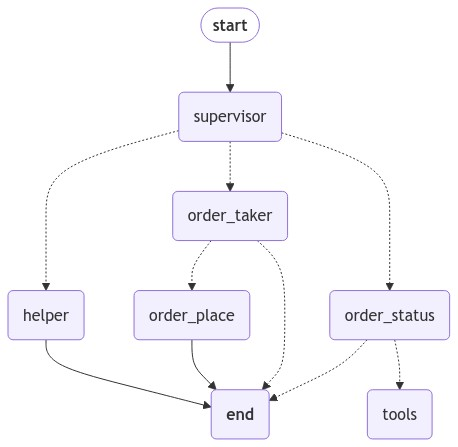

In [34]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [35]:
order_status_db

{}

In [36]:
events = graph.stream({
        "messages": [            
            HumanMessage(content="I want to order a large pizza"),
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 3},
)
for s in events:
    print(s)
    print("----")


{'supervisor': {'next': 'order_taker'}}
----
{'order_taker': {'messages': [HumanMessage(content="Certainly! I'd be happy to help you order a large pizza. Would you like to add any toppings to your pizza? We have options like capsicum, tomatoes, olives, mushrooms, onions, jalapenos, pineapple, and pepperoni.", name='order_taker', id='bf47910e-0dab-4466-94fa-f42ce2941241')], 'size': 'large', 'toppings': [], 'sides': [], 'confirmed': False}}
----


In [37]:
order_status_db

{}

In [38]:
messages = [
        HumanMessage(content="I want to order a medium pizza with onion, capsicum and tomato toppings"),
        AIMessage(content="Great choice! Would you like to add any side items, such as garlic bread, choco lava cake, or chicken taco?"),
        HumanMessage(content="Yes, add a garlic bread. Also, is a medium pizza enough for 3 people?"),
        AIMessage(content="A medium pizza is generally enough for about 2 people. Would you like to consider ordering a large pizza instead?"),
        HumanMessage(content="Yes"),
        AIMessage(content="I've updated your order to a large pizza with onion, capsicum, and tomato toppings, along with a garlic bread. Would you like to add any additional toppings or side items?"),
        HumanMessage(content="No. That's all."),
        AIMessage(content="Thank you for your order! Just to confirm, you've ordered a large pizza with onion, capsicum, and tomato toppings, along with a garlic bread. Is this correct? If so, I'll place your order."),
        HumanMessage(content="Yes, that's correct.")

]
events = graph.stream({
        "messages": messages,
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 5},
)
for s in events:
    print(s)
    print("----")

{'supervisor': {'next': 'order_taker'}}
----
{'order_taker': {'messages': [HumanMessage(content="Excellent! Your order has been confirmed. You've ordered a large pizza with onion, capsicum, and tomato toppings, along with a side of garlic bread. Your freshly baked pizza will be ready within 10 minutes. Thank you for your order, and enjoy your meal!", name='order_taker', id='0a2a2c8b-68e9-4f69-adea-2bab6f435db4')], 'size': 'large', 'toppings': ['onions', 'capsicum', 'tomatoes'], 'sides': ['garlic bread'], 'confirmed': True}}
----
{'order_place': {'messages': [AIMessage(content='Your order has been placed successfully! Your order id is: 1', name='order_place')]}}
----


In [39]:
order_status_db

{1: 'pending'}

In [40]:
messages = [
        HumanMessage(content="I want to order a medium pizza with onion, capsicum and tomato toppings and no sides. Please consider the order confirmed"),        

]
events = graph.stream({
        "messages": messages,
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 5},
)
for s in events:
    print(s)
    print("----")

{'supervisor': {'next': 'order_taker'}}
----
{'order_taker': {'messages': [HumanMessage(content="Certainly! I've confirmed your order for a medium pizza with onion, capsicum, and tomato toppings, and no sides. Your order has been placed successfully. Is there anything else you'd like to know about your order?", name='order_taker', id='8aa840a9-ac0f-493c-a175-e826bf7ae7bb')], 'size': 'medium', 'toppings': ['onions', 'capsicum', 'tomatoes'], 'sides': [], 'confirmed': True}}
----
{'order_place': {'messages': [AIMessage(content='Your order has been placed successfully! Your order id is: 2', name='order_place')]}}
----


In [41]:
order_status_db

{1: 'pending', 2: 'pending'}

In [42]:
messages = [
        HumanMessage(content="I want to know the status of my order"),
]
events = graph.stream({
        "messages": messages,
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 5},
)
for s in events:
    print(s)
    print("----")


{'supervisor': {'next': 'order_status'}}
----
{'order_status': {'messages': [HumanMessage(content="Certainly! I'd be happy to help you check the status of your order. However, to retrieve the status, I'll need the order ID. The order ID is a unique number assigned to your pizza order when it was placed.\n\nCould you please provide me with your order ID? It's usually a numerical value that you would have received when you placed your order. Once you give me the order ID, I can use it to check the status of your order.", name='order_status', id='5ecd5213-e3a8-43d1-b3bd-0bce11929067')]}}
----


In [43]:
order_status_db

{1: 'pending', 2: 'pending'}

In [44]:
messages = [
        HumanMessage(content="I want to know the status of my order"),
        AIMessage(content="Certainly! I'd be happy to help you check the status of your order. However, to retrieve the status, I'll need the order ID. The order ID is typically a number assigned to your order when you placed it.\n\nCould you please provide me with your order ID? Once I have that information, I can use our system to check the status for you."),
        HumanMessage(content="My order id is 1")
]
events = graph.stream({
        "messages": messages,
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 5},
)
for s in events:
    print(s)
    print("----")


{'supervisor': {'next': 'order_status'}}
----
{'order_status': {'messages': [HumanMessage(content="Based on the information I've received, I can inform you that Order 1 is currently pending. This means that your order has been received and is being processed, but it hasn't been completed or shipped yet.\n\nIs there anything else you'd like to know about your order or any other assistance I can provide?", name='order_status', id='ebd33648-c291-4fc3-a705-d7cf83376460')]}}
----


In [45]:
order_status_db[1]="Dispatched"

In [46]:
messages = [
        HumanMessage(content="I want to know the status of my order"),
        AIMessage(content="Certainly! I'd be happy to help you check the status of your order. However, to retrieve the status, I'll need the order ID. The order ID is typically a number assigned to your order when you placed it.\n\nCould you please provide me with your order ID? Once I have that information, I can use our system to check the status for you."),
        HumanMessage(content="My order id is 1")
]
events = graph.stream({
        "messages": messages,
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 5},
)
for s in events:
    print(s)
    print("----")


{'supervisor': {'next': 'order_status'}}
----
{'order_status': {'messages': [HumanMessage(content="Great news! I've retrieved the status of your order. The system shows that Order 1 is Dispatched. \n\nThis means that your order has been prepared and is now on its way to you. It has left our facility and is in the delivery process. You should receive it soon, depending on your location and the delivery method chosen.\n\nIs there anything else you'd like to know about your order or any other assistance I can provide?", name='order_status', id='068cf21b-00f3-4287-939b-9db0f2ea66cd')]}}
----


In [47]:
messages = [
        HumanMessage(content="I want to order a pizza with onion, capsicum and tomato toppings."),        

]
events = graph.stream({
        "messages": messages,
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 5},
)
for s in events:
    print(s)
    print("----")

{'supervisor': {'next': 'order_taker'}}
----
{'order_taker': {'messages': [HumanMessage(content="Certainly! I'd be happy to help you order a pizza with onion, capsicum, and tomato toppings. That sounds delicious! I've noted down your toppings. Could you please tell me what size pizza you'd like? We have small, medium, and large options available.", name='order_taker', id='125cafa8-5bba-46e1-9237-8f325103ee04')], 'size': 'medium', 'toppings': ['onions', 'capsicum', 'tomatoes'], 'sides': [], 'confirmed': False}}
----


In [48]:
def interactive():
    message=input("Welcome to the Robo Pizza Hut. How can I help you today?")
    print("Welcome to the Robo Pizza Hut. How can I help you today?")
    messages = [
            HumanMessage(content=message),        
        ]
    while(True):        
        if message in ["exit","q","quit"]:
            break
        messages.append(HumanMessage(content=message))
        print(message)
        events = graph.stream({
                "messages": messages,
            },
            # Maximum number of steps to take in the graph
            {"recursion_limit": 5},
        )
        events=list(events)
        # for s in events:
            # print(s)
            # print("----")
        if len(events)>0:            
            last_event=events[-1]
            v=list(last_event.values())[-1]
            if "messages" in v:
                m=v["messages"][-1]
                messages.append(AIMessage(m.content)) 
                print(m.content)            
            message=input()
        else:
            print("No event recieved")
            print(events)
            break
        

In [133]:
interactive()

Welcome to the Robo Pizza Hut. How can I help you today?
I want to order a large pizza with no toppings, no sides. Order is confirmed.
{'supervisor': {'next': 'order_taker'}}
----
{'order_taker': {'messages': [HumanMessage(content="Certainly! I've confirmed your order for a large pizza with no toppings and no side items. Your order has been placed and will be prepared shortly. Is there anything else you need?", name='order_taker', id='40de9027-a6f0-447b-a0ae-fd570f0513a8')], 'size': 'large', 'toppings': [], 'sides': [], 'confirmed': True}}
----
{'order_place': {'messages': [AIMessage(content='Your order has been placed successfully! Your order id is:\n8', name='order_place', id='9f7c21f8-ce47-4ac1-b77e-bb3cc223113a')]}}
----
---> Your order has been placed successfully! Your order id is:
8
Where is my food
{'supervisor': {'next': 'order_status'}}
----
{'order_status': {'messages': [HumanMessage(content='Based on the result from the order_status function, I can tell you that your order 